# Atividade 7 - Análise de Parâmetros do AG para TSP

**Alunos:** Luiz Henrique Oliveira Nascimento e Arthur Ângelo Gomes de Oliveira

**Professor:** Rodrigo Lira

---

## Objetivo
Investigar o impacto de diferentes parâmetros no desempenho do Algoritmo Genético

## Experimentos
1. **Tamanho da População**: 20, 50, 100 indivíduos
2. **Taxa de Mutação**: 1%, 5%, 10%, 20%
3. **Tamanho do Torneio**: 2, 3, 5, 7 competidores
4. **Elitismo**: 0, 1, 5, 10% da população preservada

Cada configuração será executada **30 vezes** para análise

## Importação de Bibliotecas

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from typing import List, Tuple
import seaborn as sns

# Configuração para gráficos
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style('whitegrid')

## Dados do TSP - Instância USA13

Utilizaremos a mesma instância USA13 da atividade anterior.

In [24]:
# Coordenadas das 13 cidades (USA13)
cidades = [
    (0, 0),      # Cidade 0
    (3, 7),      # Cidade 1
    (6, 4),      # Cidade 2
    (7, 10),     # Cidade 3
    (9, 5),      # Cidade 4
    (10, 11),    # Cidade 5
    (12, 8),     # Cidade 6
    (15, 2),     # Cidade 7
    (16, 14),    # Cidade 8
    (18, 9),     # Cidade 9
    (20, 6),     # Cidade 10
    (21, 12),    # Cidade 11
    (23, 3)      # Cidade 12
]


def calcular_distancia(cidade1: Tuple[int, int], cidade2: Tuple[int, int]) -> float:
    return np.sqrt((cidade1[0] - cidade2[0])**2 + (cidade1[1] - cidade2[1])**2)

# Criar matriz de distâncias
n_cidades = len(cidades)
matriz_distancias = np.zeros((n_cidades, n_cidades))

for i in range(n_cidades):
    for j in range(n_cidades):
        if i != j:
            matriz_distancias[i][j] = calcular_distancia(cidades[i], cidades[j])

print(f"Instância: USA13 com {n_cidades} cidades")
print(f"Matriz de distâncias: {matriz_distancias.shape}")

Instância: USA13 com 13 cidades
Matriz de distâncias: (13, 13)


## Implementação do Algoritmo Genético

In [25]:
class AlgoritmoGeneticoTSP:
    def __init__(self, matriz_distancias, tam_populacao=50, num_geracoes=400,
                 taxa_mutacao=0.05, taxa_crossover=0.8, tam_torneio=3, taxa_elitismo=0.05):
        self.matriz_distancias = matriz_distancias
        self.n_cidades = len(matriz_distancias)
        self.tam_populacao = tam_populacao
        self.num_geracoes = num_geracoes
        self.taxa_mutacao = taxa_mutacao
        self.taxa_crossover = taxa_crossover
        self.tam_torneio = tam_torneio
        self.num_elites = max(1, int(tam_populacao * taxa_elitismo))

        # Histórico
        self.historico_melhor_fitness = []
        self.historico_fitness_medio = []
        self.melhor_individuo = None
        self.melhor_fitness = float('inf')
        self.populacao_unica_por_geracao = []  

    def criar_individuo(self):
        """Cria um indivíduo aleatório (permutação das cidades)"""
        individuo = list(range(self.n_cidades))
        random.shuffle(individuo)
        return individuo

    def criar_populacao(self):
        """Cria população inicial"""
        return [self.criar_individuo() for _ in range(self.tam_populacao)]

    def calcular_fitness(self, individuo):
        """Calcula a distância total do percurso (fitness)"""
        distancia_total = 0
        for i in range(len(individuo)):
            cidade_atual = individuo[i]
            cidade_proxima = individuo[(i + 1) % len(individuo)]
            distancia_total += self.matriz_distancias[cidade_atual][cidade_proxima]
        return distancia_total

    def selecao_torneio(self, populacao, fitness_populacao):
        """Seleção por torneio"""
        competidores_idx = random.sample(range(len(populacao)), self.tam_torneio)
        competidores_fitness = [fitness_populacao[i] for i in competidores_idx]
        vencedor_idx = competidores_idx[np.argmin(competidores_fitness)]
        return populacao[vencedor_idx].copy()

    def crossover_order(self, pai1, pai2):
        """Crossover Order (OX1)"""
        if random.random() > self.taxa_crossover:
            return pai1.copy(), pai2.copy()

        tamanho = len(pai1)
        ponto1, ponto2 = sorted(random.sample(range(tamanho), 2))

        # Criar filhos
        filho1 = [-1] * tamanho
        filho2 = [-1] * tamanho

        # segmento do pai
        filho1[ponto1:ponto2] = pai1[ponto1:ponto2]
        filho2[ponto1:ponto2] = pai2[ponto1:ponto2]

        # Preencher posições
        def preencher_filho(filho, pai_doador):
            pos_filho = ponto2
            for cidade in pai_doador[ponto2:] + pai_doador[:ponto2]:
                if cidade not in filho:
                    filho[pos_filho % tamanho] = cidade
                    pos_filho += 1

        preencher_filho(filho1, pai2)
        preencher_filho(filho2, pai1)

        return filho1, filho2

    def mutacao_swap(self, individuo):
        """Mutação por troca de duas cidades"""
        if random.random() < self.taxa_mutacao:
            idx1, idx2 = random.sample(range(len(individuo)), 2)
            individuo[idx1], individuo[idx2] = individuo[idx2], individuo[idx1]
        return individuo

    def contar_individuos_unicos(self, populacao):
        """Conta quantos indivíduos únicos existem na população"""
        unicos = set()
        for individuo in populacao:
            unicos.add(tuple(individuo))
        return len(unicos)

    def executar(self, verbose=False):
        """Executa o algoritmo genético"""
        # Inicializar população
        populacao = self.criar_populacao()

        for geracao in range(self.num_geracoes):
            
            fitness_populacao = [self.calcular_fitness(ind) for ind in populacao]

        
            melhor_fitness_geracao = min(fitness_populacao)
            idx_melhor = fitness_populacao.index(melhor_fitness_geracao)

            if melhor_fitness_geracao < self.melhor_fitness:
                self.melhor_fitness = melhor_fitness_geracao
                self.melhor_individuo = populacao[idx_melhor].copy()

        
            self.historico_melhor_fitness.append(self.melhor_fitness)
            self.historico_fitness_medio.append(np.mean(fitness_populacao))

            unicos = self.contar_individuos_unicos(populacao)
            self.populacao_unica_por_geracao.append(unicos)

            if verbose and geracao % 50 == 0:
                print(f"Geração {geracao}: Melhor fitness = {self.melhor_fitness:.2f}, "
                      f"Indivíduos únicos = {unicos}/{self.tam_populacao}")

            # Elitismo: preservar os melhores
            populacao_ordenada = [x for _, x in sorted(zip(fitness_populacao, populacao))]
            nova_populacao = populacao_ordenada[:self.num_elites]

        
            while len(nova_populacao) < self.tam_populacao:
                pai1 = self.selecao_torneio(populacao, fitness_populacao)
                pai2 = self.selecao_torneio(populacao, fitness_populacao)

                filho1, filho2 = self.crossover_order(pai1, pai2)

                filho1 = self.mutacao_swap(filho1)
                filho2 = self.mutacao_swap(filho2)

                nova_populacao.append(filho1)
                if len(nova_populacao) < self.tam_populacao:
                    nova_populacao.append(filho2)

            populacao = nova_populacao

        return self.melhor_individuo, self.melhor_fitness

## Funções Auxiliares para Experimentos

In [26]:
def executar_multiplas_vezes(matriz_distancias, num_execucoes=30, **kwargs):
    """
    Executa o AG múltiplas vezes e coleta estatísticas
    """
    resultados = {
        'fitness_finais': [],
        'historicos_convergencia': [],
        'tempos_execucao': [],
        'diversidade_final': []
    }

    for i in range(num_execucoes):
        ag = AlgoritmoGeneticoTSP(matriz_distancias, **kwargs)

        inicio = time.time()
        melhor_ind, melhor_fit = ag.executar()
        tempo = time.time() - inicio

        resultados['fitness_finais'].append(melhor_fit)
        resultados['historicos_convergencia'].append(ag.historico_melhor_fitness)
        resultados['tempos_execucao'].append(tempo)
        resultados['diversidade_final'].append(ag.populacao_unica_por_geracao[-1])

        if (i + 1) % 10 == 0:
            print(f"  Execução {i+1}/{num_execucoes} concluída")

    # Calcular estatísticas
    resultados['media'] = np.mean(resultados['fitness_finais'])
    resultados['desvio_padrao'] = np.std(resultados['fitness_finais'])
    resultados['melhor'] = np.min(resultados['fitness_finais'])
    resultados['pior'] = np.max(resultados['fitness_finais'])
    resultados['tempo_medio'] = np.mean(resultados['tempos_execucao'])

    return resultados

def plotar_convergencia_comparativa(resultados_dict, titulo, nome_arquivo):
    """
    Plota gráficos de convergência para múltiplas configurações
    """
    plt.figure(figsize=(14, 7))

    cores = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

    for idx, (label, resultado) in enumerate(resultados_dict.items()):
        # Calcular média das convergências
        historicos = np.array(resultado['historicos_convergencia'])
        media_convergencia = np.mean(historicos, axis=0)

        plt.plot(media_convergencia, label=label, linewidth=2.5, color=cores[idx % len(cores)])

    plt.xlabel('Geração', fontsize=12)
    plt.ylabel('Melhor Fitness (Distância)', fontsize=12)
    plt.title(titulo, fontsize=14, fontweight='bold')
    plt.legend(fontsize=11, loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(nome_arquivo, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Gráfico salvo: {nome_arquivo}")

def plotar_boxplot_comparativo(resultados_dict, titulo, nome_arquivo):
    """
    Cria boxplot comparativo entre configurações
    """
    plt.figure(figsize=(12, 7))

    dados = [resultado['fitness_finais'] for resultado in resultados_dict.values()]
    labels = list(resultados_dict.keys())

    bp = plt.boxplot(dados, labels=labels, patch_artist=True,
                     notch=True, showmeans=True)

    # Colorir boxes
    cores = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    for patch, cor in zip(bp['boxes'], cores):
        patch.set_facecolor(cor)
        patch.set_alpha(0.7)

    plt.ylabel('Melhor Fitness Final', fontsize=12)
    plt.title(titulo, fontsize=14, fontweight='bold')
    plt.xticks(rotation=15, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig(nome_arquivo, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Boxplot salvo: {nome_arquivo}")

def imprimir_estatisticas(resultados_dict):
    """
    Imprime estatísticas comparativas
    """
    print("\n" + "="*80)
    print("ESTATÍSTICAS COMPARATIVAS")
    print("="*80)
    print(f"{'Configuração':<25} {'Média':<10} {'DP':<10} {'Melhor':<10} {'Pior':<10} {'Tempo(s)'}")
    print("-"*80)

    for label, resultado in resultados_dict.items():
        print(f"{label:<25} {resultado['media']:<10.2f} {resultado['desvio_padrao']:<10.2f} "
              f"{resultado['melhor']:<10.2f} {resultado['pior']:<10.2f} {resultado['tempo_medio']:<10.2f}")
    print("="*80 + "\n")

---
# EXPERIMENTO 1: Tamanho da População
**Objetivo:** Analisar o impacto do tamanho da população na convergência e qualidade das soluções.

**Configurações testadas:** 20, 50, 100 indivíduos

**Parâmetros fixos:**
- Gerações: 400
- Taxa de mutação: 5%
- Tamanho do torneio: 3
- Elitismo: 5%

EXPERIMENTO 1: TAMANHO DA POPULAÇÃO

 Testando população de 20 indivíduos...
  Execução 10/30 concluída
  Execução 20/30 concluída
  Execução 30/30 concluída

 Testando população de 50 indivíduos...
  Execução 10/30 concluída
  Execução 20/30 concluída
  Execução 30/30 concluída

 Testando população de 100 indivíduos...
  Execução 10/30 concluída
  Execução 20/30 concluída
  Execução 30/30 concluída

ESTATÍSTICAS COMPARATIVAS
Configuração              Média      DP         Melhor     Pior       Tempo(s)
--------------------------------------------------------------------------------
Pop=20                    72.73      3.06       69.21      79.94      0.15      
Pop=50                    71.64      3.26       69.21      82.40      0.41      
Pop=100                   70.03      1.86       69.21      76.56      0.80      



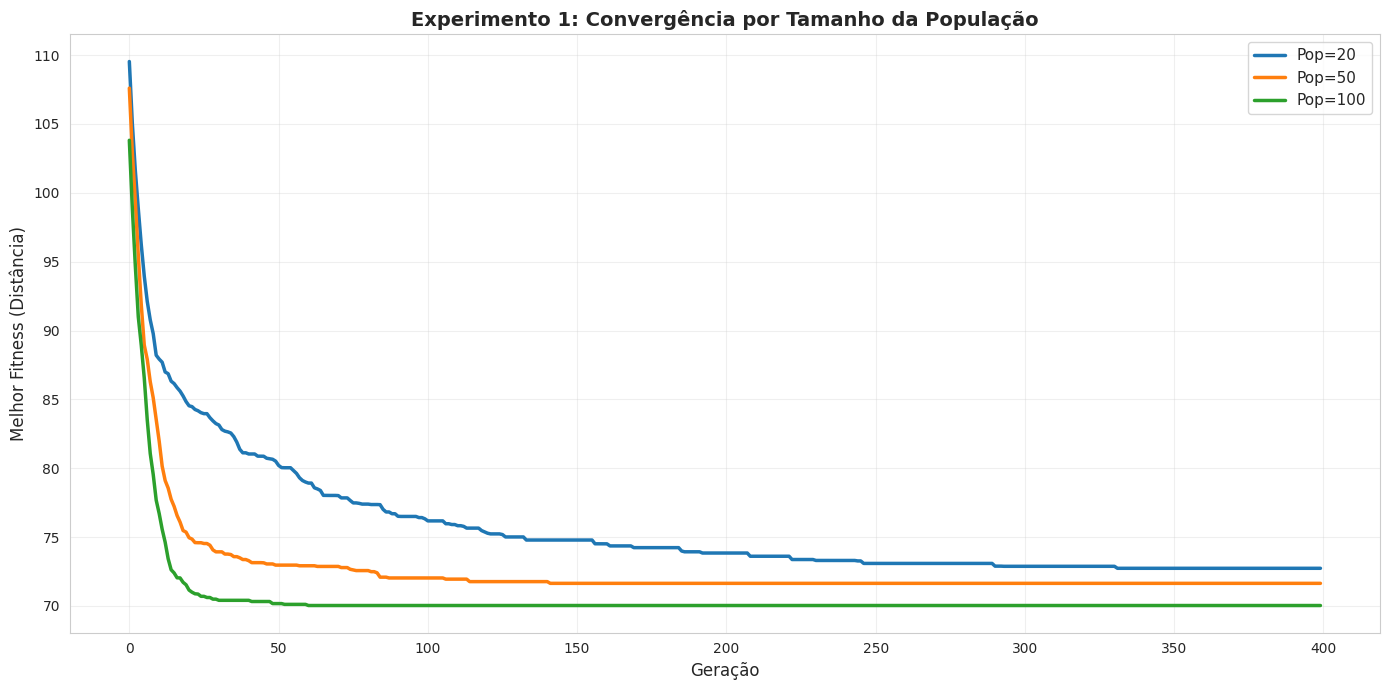

✓ Gráfico salvo: exp1_convergencia.png


/tmp/ipython-input-2784162056.py:70: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(dados, labels=labels, patch_artist=True,


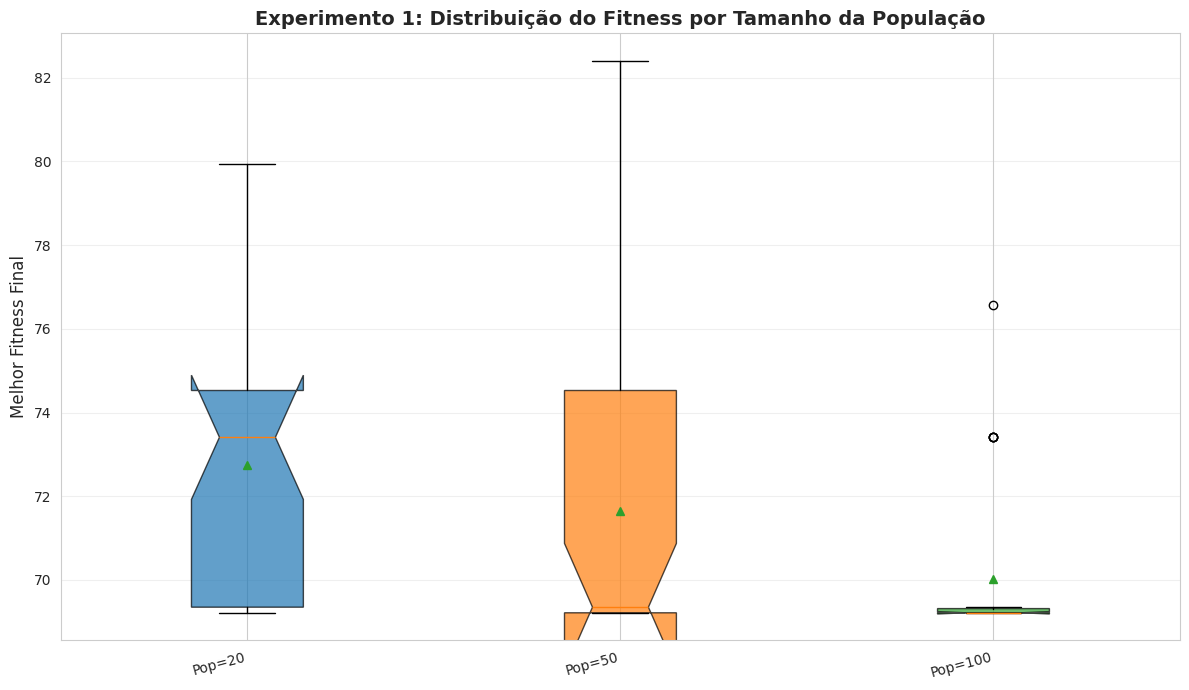

✓ Boxplot salvo: exp1_boxplot.png


In [27]:
print("="*80)
print("EXPERIMENTO 1: TAMANHO DA POPULAÇÃO")
print("="*80)

tamanhos_pop = [20, 50, 100]
resultados_exp1 = {}

for tam in tamanhos_pop:
    print(f"\n Testando população de {tam} indivíduos...")
    resultados_exp1[f"Pop={tam}"] = executar_multiplas_vezes(
        matriz_distancias,
        num_execucoes=30,
        tam_populacao=tam,
        num_geracoes=400,
        taxa_mutacao=0.05,
        tam_torneio=3,
        taxa_elitismo=0.05
    )

# Estatísticas
imprimir_estatisticas(resultados_exp1)

# Gráficos
plotar_convergencia_comparativa(
    resultados_exp1,
    "Experimento 1: Convergência por Tamanho da População",
    "exp1_convergencia.png"
)

plotar_boxplot_comparativo(
    resultados_exp1,
    "Experimento 1: Distribuição do Fitness por Tamanho da População",
    "exp1_boxplot.png"
)

---
# EXPERIMENTO 2: Taxa de Mutação
**Objetivo:** Avaliar como diferentes taxas de mutação afetam a exploração do espaço de busca.

**Configurações testadas:** 1%, 5%, 10%, 20%

**Parâmetros fixos:**
- População: 50 indivíduos
- Gerações: 400
- Tamanho do torneio: 3
- Elitismo: 5%

EXPERIMENTO 2: TAXA DE MUTAÇÃO

 Testando taxa de mutação de 1%...
  Execução 10/30 concluída
  Execução 20/30 concluída
  Execução 30/30 concluída

 Testando taxa de mutação de 5%...
  Execução 10/30 concluída
  Execução 20/30 concluída
  Execução 30/30 concluída

 Testando taxa de mutação de 10%...
  Execução 10/30 concluída
  Execução 20/30 concluída
  Execução 30/30 concluída

 Testando taxa de mutação de 20%...
  Execução 10/30 concluída
  Execução 20/30 concluída
  Execução 30/30 concluída

ESTATÍSTICAS COMPARATIVAS
Configuração              Média      DP         Melhor     Pior       Tempo(s)
--------------------------------------------------------------------------------
Mutação=1%                72.26      3.23       69.21      81.28      0.40      
Mutação=5%                70.99      2.14       69.21      75.47      0.41      
Mutação=10%               71.09      2.49       69.21      76.56      0.40      
Mutação=20%               70.41      2.19       69.21      76.56     

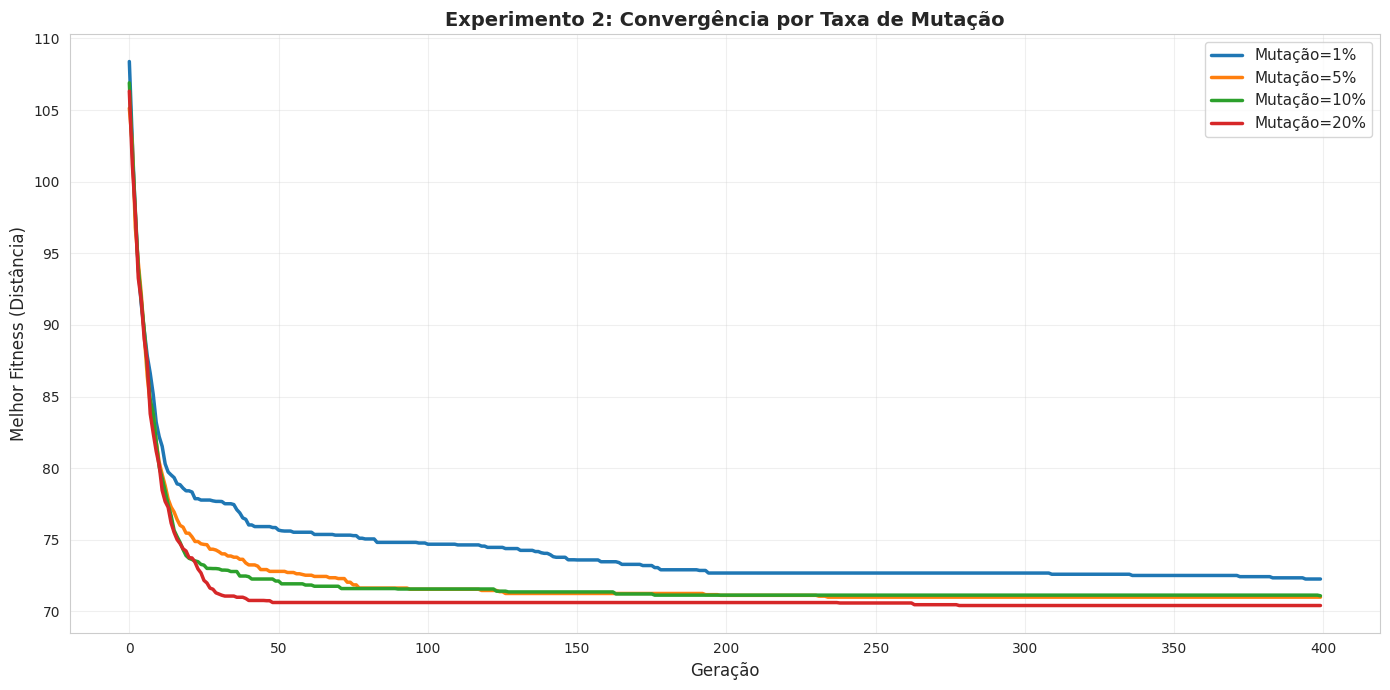

✓ Gráfico salvo: exp2_convergencia.png


/tmp/ipython-input-2784162056.py:70: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(dados, labels=labels, patch_artist=True,


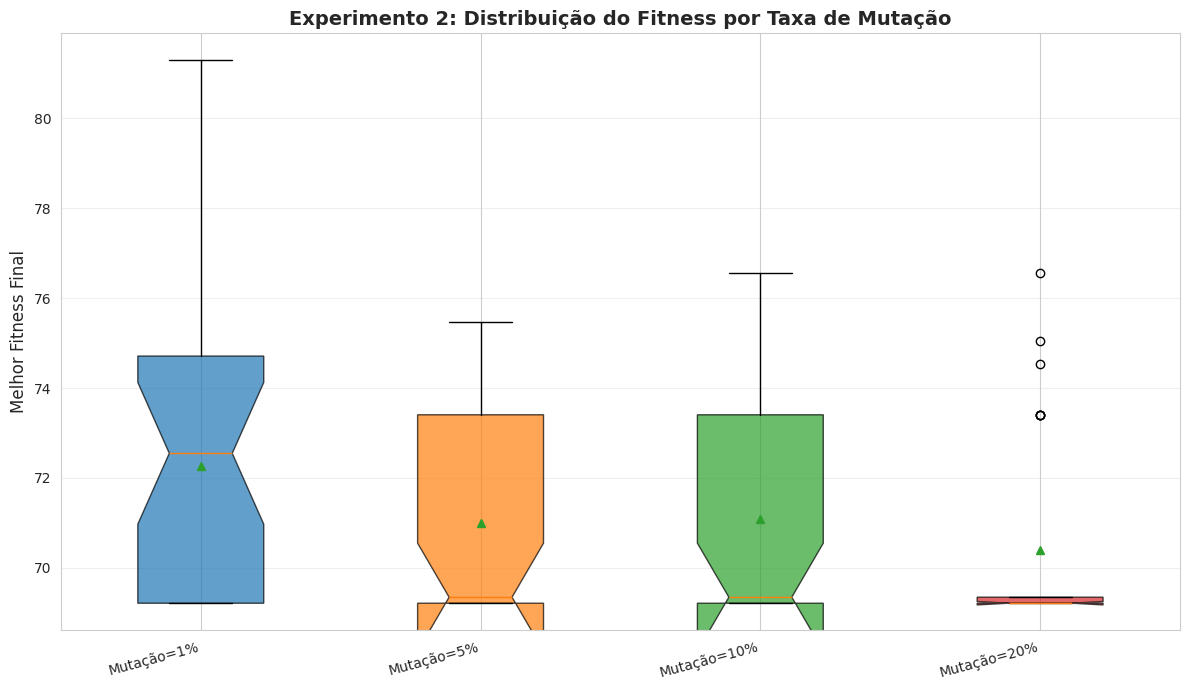

✓ Boxplot salvo: exp2_boxplot.png


In [28]:
print("="*80)
print("EXPERIMENTO 2: TAXA DE MUTAÇÃO")
print("="*80)

taxas_mutacao = [0.01, 0.05, 0.10, 0.20]
resultados_exp2 = {}

for taxa in taxas_mutacao:
    print(f"\n Testando taxa de mutação de {taxa*100:.0f}%...")
    resultados_exp2[f"Mutação={taxa*100:.0f}%"] = executar_multiplas_vezes(
        matriz_distancias,
        num_execucoes=30,
        tam_populacao=50,
        num_geracoes=400,
        taxa_mutacao=taxa,
        tam_torneio=3,
        taxa_elitismo=0.05
    )

# Estatísticas
imprimir_estatisticas(resultados_exp2)

# Gráficos
plotar_convergencia_comparativa(
    resultados_exp2,
    "Experimento 2: Convergência por Taxa de Mutação",
    "exp2_convergencia.png"
)

plotar_boxplot_comparativo(
    resultados_exp2,
    "Experimento 2: Distribuição do Fitness por Taxa de Mutação",
    "exp2_boxplot.png"
)

---
# EXPERIMENTO 3: Tamanho do Torneio
**Objetivo:** Investigar o efeito da pressão seletiva no algoritmo através do tamanho do torneio.

**Configurações testadas:** 2, 3, 5, 7 competidores

**Parâmetros fixos:**
- População: 50 indivíduos
- Gerações: 400
- Taxa de mutação: 5%
- Elitismo: 5%

**Análise adicional:** Verificar diversidade populacional ao longo das gerações.

EXPERIMENTO 3: TAMANHO DO TORNEIO

 Testando torneio com 2 competidores...
  Execução 10/30 concluída
  Execução 20/30 concluída
  Execução 30/30 concluída

 Testando torneio com 3 competidores...
  Execução 10/30 concluída
  Execução 20/30 concluída
  Execução 30/30 concluída

 Testando torneio com 5 competidores...
  Execução 10/30 concluída
  Execução 20/30 concluída
  Execução 30/30 concluída

 Testando torneio com 7 competidores...
  Execução 10/30 concluída
  Execução 20/30 concluída
  Execução 30/30 concluída

ESTATÍSTICAS COMPARATIVAS
Configuração              Média      DP         Melhor     Pior       Tempo(s)
--------------------------------------------------------------------------------
Torneio=2                 70.78      2.24       69.21      75.47      0.39      
Torneio=3                 71.09      2.73       69.21      79.13      0.40      
Torneio=5                 72.99      4.58       69.21      89.46      0.42      
Torneio=7                 71.59      2.86       

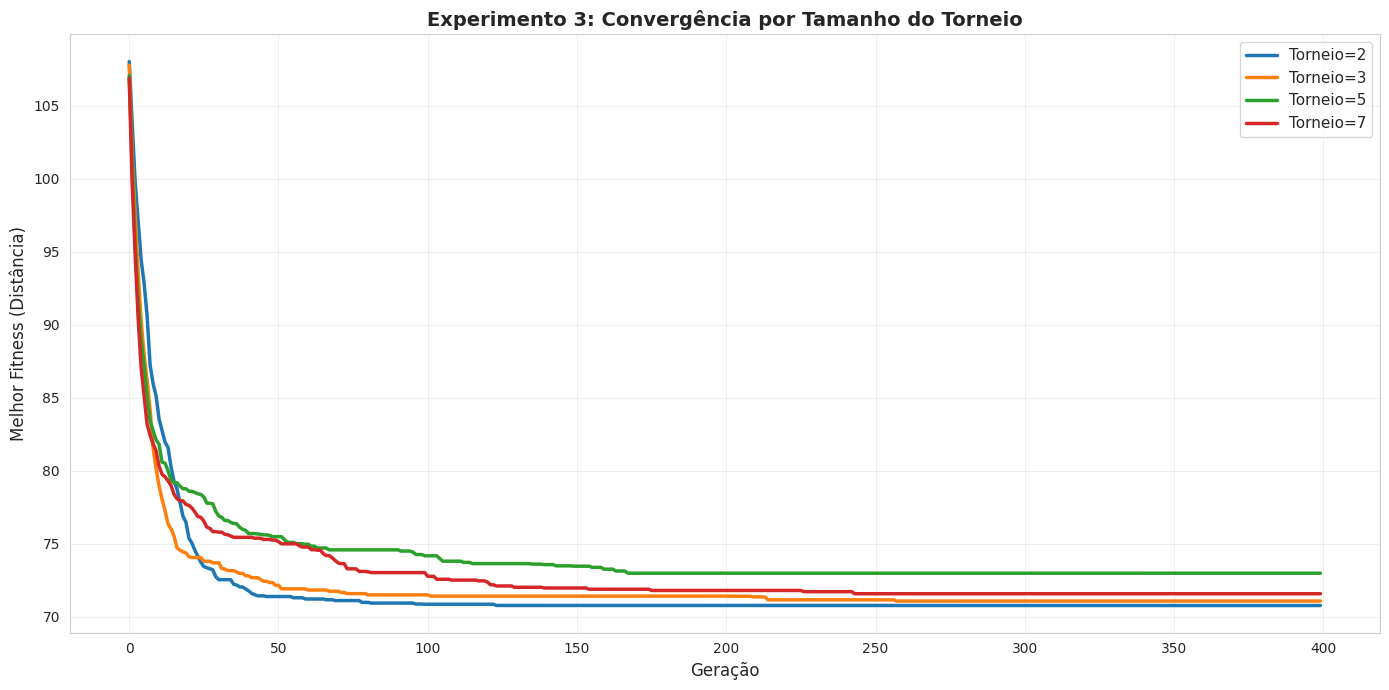

✓ Gráfico salvo: exp3_convergencia.png


/tmp/ipython-input-2784162056.py:70: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(dados, labels=labels, patch_artist=True,


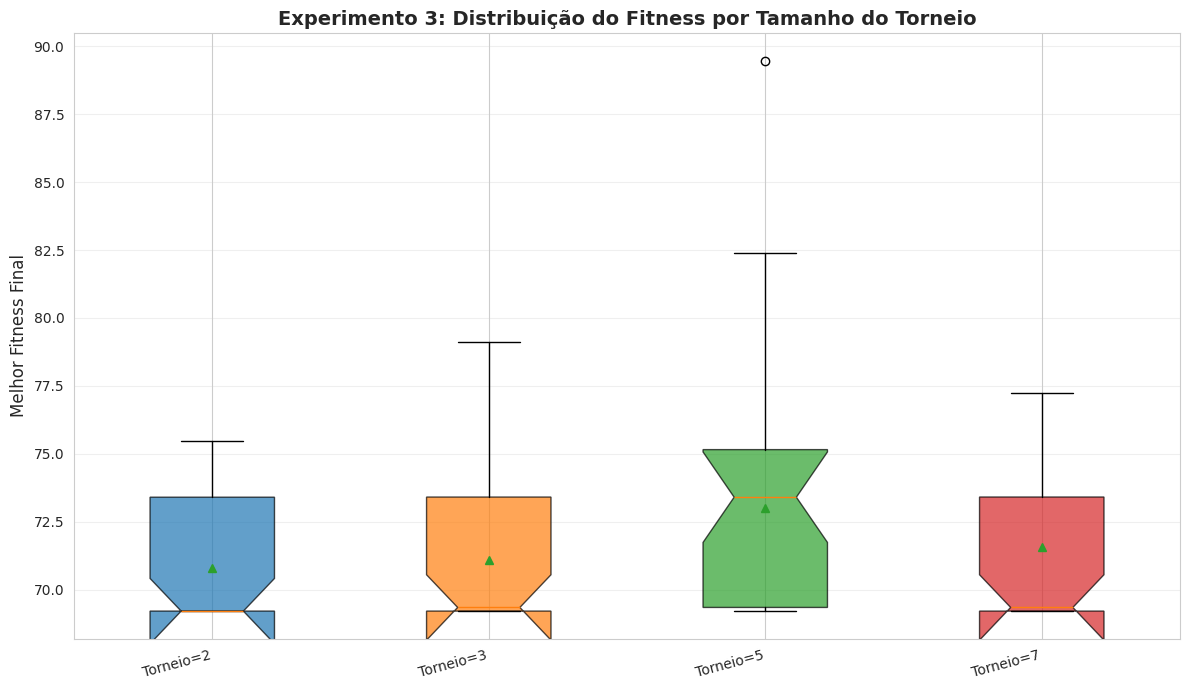

✓ Boxplot salvo: exp3_boxplot.png

ANÁLISE DE DIVERSIDADE POPULACIONAL
Torneio         Indivíduos únicos (média final)     % da população
--------------------------------------------------------------------------------
Torneio=2       3.70                                7.4%
Torneio=3       3.83                                7.7%
Torneio=5       3.40                                6.8%
Torneio=7       3.77                                7.5%



In [29]:
print("="*80)
print("EXPERIMENTO 3: TAMANHO DO TORNEIO")
print("="*80)

tamanhos_torneio = [2, 3, 5, 7]
resultados_exp3 = {}

for tam in tamanhos_torneio:
    print(f"\n Testando torneio com {tam} competidores...")
    resultados_exp3[f"Torneio={tam}"] = executar_multiplas_vezes(
        matriz_distancias,
        num_execucoes=30,
        tam_populacao=50,
        num_geracoes=400,
        taxa_mutacao=0.05,
        tam_torneio=tam,
        taxa_elitismo=0.05
    )

# Estatísticas
imprimir_estatisticas(resultados_exp3)

# Gráficos
plotar_convergencia_comparativa(
    resultados_exp3,
    "Experimento 3: Convergência por Tamanho do Torneio",
    "exp3_convergencia.png"
)

plotar_boxplot_comparativo(
    resultados_exp3,
    "Experimento 3: Distribuição do Fitness por Tamanho do Torneio",
    "exp3_boxplot.png"
)

# Análise de diversidade populacional
print("\n" + "="*80)
print("ANÁLISE DE DIVERSIDADE POPULACIONAL")
print("="*80)
print(f"{'Torneio':<15} {'Indivíduos únicos (média final)':<35} {'% da população'}")
print("-"*80)

for label, resultado in resultados_exp3.items():
    media_diversidade = np.mean(resultado['diversidade_final'])
    percentual = (media_diversidade / 50) * 100
    print(f"{label:<15} {media_diversidade:<35.2f} {percentual:.1f}%")

print("="*80 + "\n")

---
# EXPERIMENTO 4: Elitismo
**Objetivo:** Analisar o impacto da preservação dos melhores indivíduos entre gerações.

**Configurações testadas:** 0, 1, 5, 10% da população preservada

**Parâmetros fixos:**
- População: 50 indivíduos
- Gerações: 400
- Taxa de mutação: 5%
- Tamanho do torneio: 3

EXPERIMENTO 4: ELITISMO

 Testando elitismo de 0%...
  Execução 10/30 concluída
  Execução 20/30 concluída
  Execução 30/30 concluída

 Testando elitismo de 1%...
  Execução 10/30 concluída
  Execução 20/30 concluída
  Execução 30/30 concluída

 Testando elitismo de 5%...
  Execução 10/30 concluída
  Execução 20/30 concluída
  Execução 30/30 concluída

 Testando elitismo de 10%...
  Execução 10/30 concluída
  Execução 20/30 concluída
  Execução 30/30 concluída

ESTATÍSTICAS COMPARATIVAS
Configuração              Média      DP         Melhor     Pior       Tempo(s)
--------------------------------------------------------------------------------
Elitismo=0%               71.11      2.65       69.21      79.13      0.41      
Elitismo=1%               71.40      2.72       69.21      77.15      0.41      
Elitismo=5%               71.94      2.84       69.21      77.15      0.41      
Elitismo=10%              72.42      4.04       69.21      87.05      0.39      



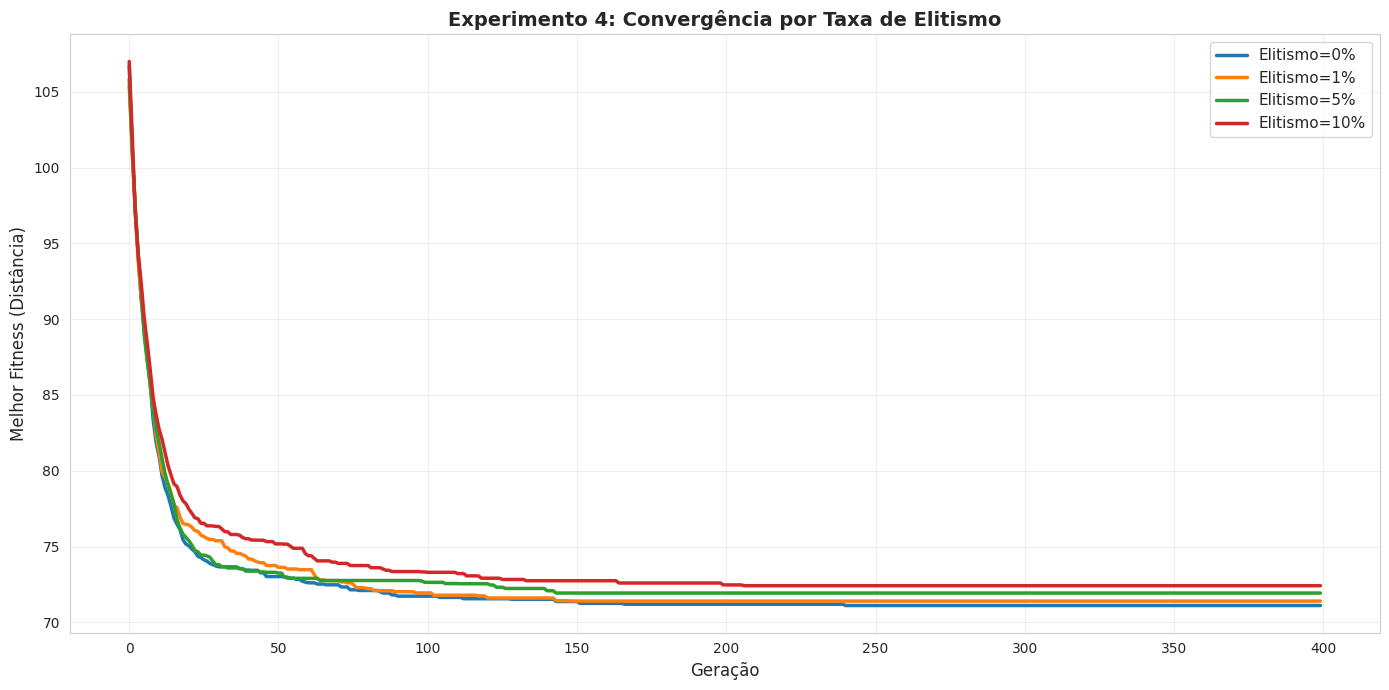

✓ Gráfico salvo: exp4_convergencia.png


/tmp/ipython-input-2784162056.py:70: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(dados, labels=labels, patch_artist=True,


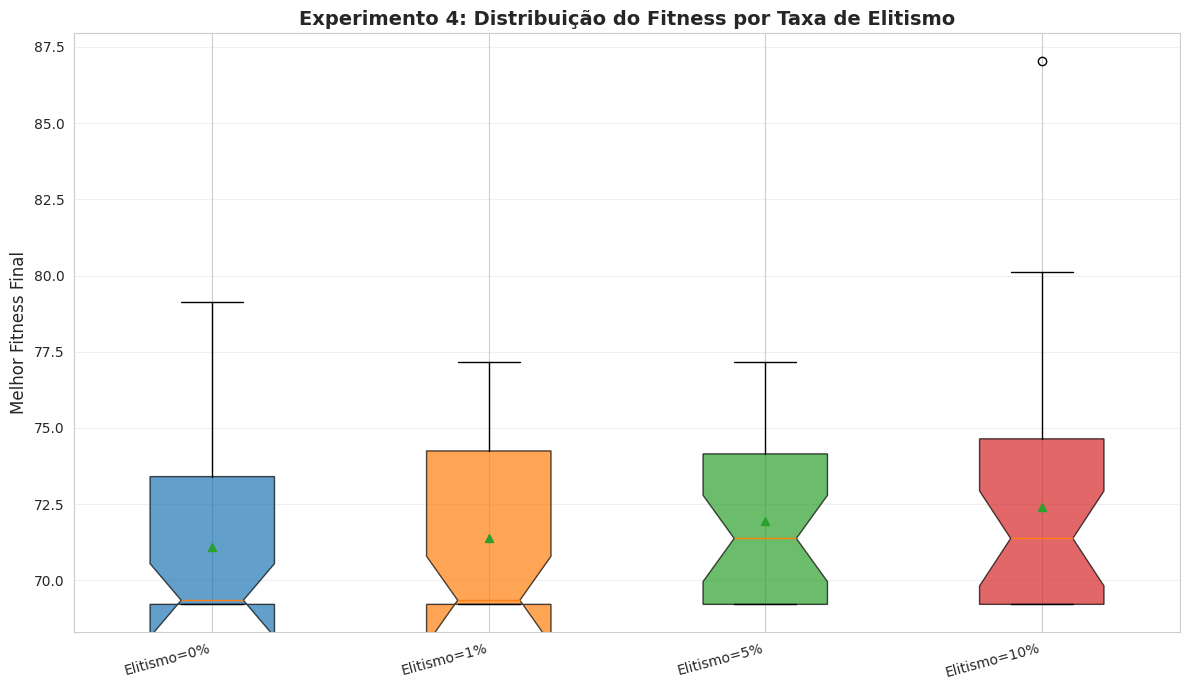

✓ Boxplot salvo: exp4_boxplot.png


In [30]:
print("="*80)
print("EXPERIMENTO 4: ELITISMO")
print("="*80)

taxas_elitismo = [0.0, 0.01, 0.05, 0.10]
resultados_exp4 = {}

for taxa in taxas_elitismo:
    print(f"\n Testando elitismo de {taxa*100:.0f}%...")
    resultados_exp4[f"Elitismo={taxa*100:.0f}%"] = executar_multiplas_vezes(
        matriz_distancias,
        num_execucoes=30,
        tam_populacao=50,
        num_geracoes=400,
        taxa_mutacao=0.05,
        tam_torneio=3,
        taxa_elitismo=taxa
    )

# Estatísticas
imprimir_estatisticas(resultados_exp4)

# Gráficos
plotar_convergencia_comparativa(
    resultados_exp4,
    "Experimento 4: Convergência por Taxa de Elitismo",
    "exp4_convergencia.png"
)

plotar_boxplot_comparativo(
    resultados_exp4,
    "Experimento 4: Distribuição do Fitness por Taxa de Elitismo",
    "exp4_boxplot.png"
)

In [31]:
print("\n" + "="*80)
print("RESUMO GERAL - MELHORES CONFIGURAÇÕES")
print("="*80)

todos_experimentos = {
    "Exp 1 - População": resultados_exp1,
    "Exp 2 - Mutação": resultados_exp2,
    "Exp 3 - Torneio": resultados_exp3,
    "Exp 4 - Elitismo": resultados_exp4
}

for exp_nome, exp_resultados in todos_experimentos.items():
    melhor_config = min(exp_resultados.items(), key=lambda x: x[1]['media'])
    print(f"\n{exp_nome}:")
    print(f"  Melhor configuração: {melhor_config[0]}")
    print(f"  Fitness médio: {melhor_config[1]['media']:.2f}")
    print(f"  Desvio padrão: {melhor_config[1]['desvio_padrao']:.2f}")
    print(f"  Melhor resultado: {melhor_config[1]['melhor']:.2f}")



RESUMO GERAL - MELHORES CONFIGURAÇÕES

Exp 1 - População:
  Melhor configuração: Pop=100
  Fitness médio: 70.03
  Desvio padrão: 1.86
  Melhor resultado: 69.21

Exp 2 - Mutação:
  Melhor configuração: Mutação=20%
  Fitness médio: 70.41
  Desvio padrão: 2.19
  Melhor resultado: 69.21

Exp 3 - Torneio:
  Melhor configuração: Torneio=2
  Fitness médio: 70.78
  Desvio padrão: 2.24
  Melhor resultado: 69.21

Exp 4 - Elitismo:
  Melhor configuração: Elitismo=0%
  Fitness médio: 71.11
  Desvio padrão: 2.65
  Melhor resultado: 69.21
